In this notebook, we test out hyperparameter tuning with Optuna. again. with GNBlocks and only 5 edges per node. Also we restrict the range of possible parameter values to more closely match GNBLock_baseline because we know we got not-insane results from there. 

similar to sandbox 8 but with larger dataset and slightly tweaked param ranges.

similar to sandbox 9 except we properly added pruning and intermediate values. also we fix the fact that we accidentally put relu on the last MLP layer, which was preventing the model from predicting any negative values. :clown: 

we do a baby test with 10 epochs to see if we can get negative values now 

### imports and setup

In [1]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [18]:
from utils.jraph_training import train_and_evaluate_with_data, create_dataset
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 

In [3]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### set up functions for optuna

In [4]:
CHECKPOINT_PATH = "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/experiments/tuning"

In [5]:
def objective(trial, study_name, datasets):
    """ Defines the objective function to be optimized over, aka the validation loss of a model.
    
        Args:
            trial: object which characterizes the current run 
            datasets: dictionary of data. we explicitly pass this in so that we don't have to waste runtime regenerating the same dataset over and over. 
    """
    # create config 
    config = ml_collections.ConfigDict()

    # Optimizer.
    # config.optimizer = "adam"
    config.optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    config.learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, 
                                               log=True)
    if config.optimizer == "sgd":
        config.momentum = trial.suggest_float('momentum', 0, 0.999) # upper bound is inclusive, and we want to exclude a momentum of 1 because that would yield no decay 

    # Data params that are used in training 
    config.output_steps = 4

    # Training hyperparameters.
    config.batch_size = 1 # variable currently not used
    config.epochs = 10
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    config.model = 'MLPBlock'
    config.dropout_rate = trial.suggest_float('dropout_rate', 0, 0.6)
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.activation = trial.suggest_categorical(
        'activation', ["relu", "elu", "leaky_relu"])
    
    # choose the hidden layer feature size using powers of 2 
    config.edge_features = (
        2**trial.suggest_int("edge_mlp_1_power", 1, 3), # range 2 - 8; upper bound is inclusive
        2**trial.suggest_int("edge_mlp_2_power", 1, 3), # range 2 - 8
    )
    config.node_features = (
        2**trial.suggest_int("node_mlp_1_power", 1, 8), # range 2 - 512
        2**trial.suggest_int("node_mlp_2_power", 1, 8), # range 2 - 512
        2) 
    # note the last feature size will be the number of features that the graph predicts
    config.global_features = None

    # generate a workdir 
    # TODO: check if we actually care about referencing this in the future or if we can just create a temp dir 
    workdir=os.path.join(CHECKPOINT_PATH, study_name, f"trial_{trial.number}")

    # run training 
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
    
    # retrieve and return val loss (MSE)
    # print("eval_metrics_dict['val'].loss", eval_metrics_dict['val'].loss)
    print("eval_metrics_dict['val'].compute()['loss']", eval_metrics_dict['val'].compute()['loss'])
    print()
    return eval_metrics_dict['val'].compute()['loss']




In [6]:
def get_data_config():
    config = ml_collections.ConfigDict()

    config.n_samples=10_000
    config.input_steps=1
    config.output_delay=8 # predict 24 hrs into the future 
    config.output_steps=4
    config.timestep_duration=3 # equivalent to 3 hours
    # note a 3 hour timestep resolution would be 5*24/3=40
    # if the time_resolution is 120, then a sampling frequency of 3 would achieve a 3 hour timestep 
    config.sample_buffer = -1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
        # number of timesteps strictly between the end 
        # of one full sample and the start of the next sample
    config.time_resolution=120 # the number of 
                # raw data points generated per time unit, equivalent to the 
                # number of data points generated per 5 days in the simulation
    config.init_buffer_samples=100
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=42
    config.normalize=True
    config.fully_connected_edges=False

    return config

In [7]:
def prepare_study(study_name):
    # generate dataset 
    dataset_config = get_data_config()
    datasets = create_dataset(dataset_config)
    print_graph_fts(datasets['train']['inputs'][0][0])

    # get the objective function that reuses the pre-generated datasets 
    objective_partial = partial(objective, study_name=study_name, 
                                datasets=datasets)

    # run optimization study
    db_path = os.path.join(CHECKPOINT_PATH, study_name, "optuna_hparam_search.db")
    if not os.path.exists(os.path.join(CHECKPOINT_PATH, study_name)):
        os.makedirs(os.path.join(CHECKPOINT_PATH, study_name))

    study = optuna.create_study(
        study_name=study_name,
        storage=f'sqlite:///{db_path}', # generates a new db if it doesn't exist
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5, 
            n_warmup_steps=50,
            ), 
        load_if_exists=True, 
    )
    
    return study, objective_partial

### try hyperparameter tuning again with fewer params and lower learning rate options

In [8]:
# get study
study10, objective_partial = prepare_study(study_name="hparam_study_10")

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


[I 2023-12-01 21:34:39,099] A new study created in RDB with name: hparam_study_10


In [9]:
study10.optimize(objective_partial, 
                n_trials=5-len(study10.trials), 
                n_jobs=1)

[I 2023-12-01 21:36:47,959] Trial 0 finished with value: 77431432019968.0 and parameters: {'optimizer': 'adam', 'learning_rate': 0.021352210126846245, 'dropout_rate': 0.3008231602219968, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5, 'node_mlp_2_power': 7}. Best is trial 0 with value: 77431432019968.0.


eval_metrics_dict['val'].compute()['loss'] 77431430000000.0



[I 2023-12-01 21:38:49,454] Trial 1 finished with value: 0.6714913845062256 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0002483783627777202, 'momentum': 0.7508533198246197, 'dropout_rate': 0.09417768846793652, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 1, 'node_mlp_2_power': 7}. Best is trial 1 with value: 0.6714913845062256.


eval_metrics_dict['val'].compute()['loss'] 0.6714914



[I 2023-12-01 21:40:00,171] Trial 2 finished with value: 0.919899046421051 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0013400805643265128, 'momentum': 0.13751870592218196, 'dropout_rate': 0.3377778433488484, 'activation': 'leaky_relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 1, 'node_mlp_2_power': 1}. Best is trial 1 with value: 0.6714913845062256.


eval_metrics_dict['val'].compute()['loss'] 0.91989905



[I 2023-12-01 21:41:19,841] Trial 3 finished with value: 0.8291878700256348 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.021645855443306567, 'momentum': 0.05656239835897409, 'dropout_rate': 0.3304123686610147, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 6, 'node_mlp_2_power': 1}. Best is trial 1 with value: 0.6714913845062256.


eval_metrics_dict['val'].compute()['loss'] 0.82918787



[I 2023-12-01 21:46:16,284] Trial 4 finished with value: 0.48924770951271057 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0024501137550815813, 'dropout_rate': 0.04925725012221116, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 8, 'node_mlp_2_power': 8}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.4892477



ok it's weird that we are occasionally still getting huge errors. and in the below run we got a nan result which could be from exploding errors? 

still trial 4 is extremely promising with just 10 epochs of training! 

In [10]:
study10.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[77431432019968.0], datetime_start=datetime.datetime(2023, 12, 1, 21, 34, 39, 240834), datetime_complete=datetime.datetime(2023, 12, 1, 21, 36, 47, 938704), params={'optimizer': 'adam', 'learning_rate': 0.021352210126846245, 'dropout_rate': 0.3008231602219968, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 5, 'node_mlp_2_power': 7}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.8588842749595642, 5: 307.11297607421875, 9: 77431432019968.0}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd')), 'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'leaky_relu')), 'edge_mlp_1_power': IntDistribution(high=3, log=False, low=1, step=1), 'edge_mlp_2_power': IntDistribution(high=3, log=False, low=1, st

let's plot the best trial predictions so far

In [25]:
def get_best_trial_config(study):
    dataset_config = get_data_config()
    best_trial_config = dataset_config

    # Optimizer.
    best_trial_config.optimizer = study.best_params['optimizer']
    best_trial_config.learning_rate = study.best_params['learning_rate']
    if best_trial_config.optimizer == "sgd":
        best_trial_config.momentum = study.best_params['momentu,']

    # Training hyperparameters.
    # best_trial_config.batch_size = 1 # variable currently not used
    # best_trial_config.epochs = 10
    # best_trial_config.log_every_epochs = 5
    # best_trial_config.eval_every_epochs = 5
    # best_trial_config.checkpoint_every_epochs = 10

    # GNN hyperparameters.
    best_trial_config.model = 'MLPBlock'
    best_trial_config.dropout_rate = study.best_params['dropout_rate']
    best_trial_config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    best_trial_config.layer_norm = False # TODO perhaps we want to turn on later
    best_trial_config.activation = study.best_params['activation']

    # choose the hidden layer feature size using powers of 2 
    best_trial_config.edge_features = (
        2**study.best_params["edge_mlp_1_power"],
        2**study.best_params["edge_mlp_2_power"],
    )
    best_trial_config.node_features = (
        2**study.best_params["node_mlp_1_power"],
        2**study.best_params["node_mlp_2_power"],
        2) 
    # note the last feature size will be the number of features that the graph predicts
    best_trial_config.global_features = None

    return best_trial_config

def get_best_trial_workdir(study):
    workdir=os.path.join(CHECKPOINT_PATH, study.study_name, f"trial_{study.best_trial.number}")
    return workdir


In [16]:
datasets = create_dataset(get_data_config())

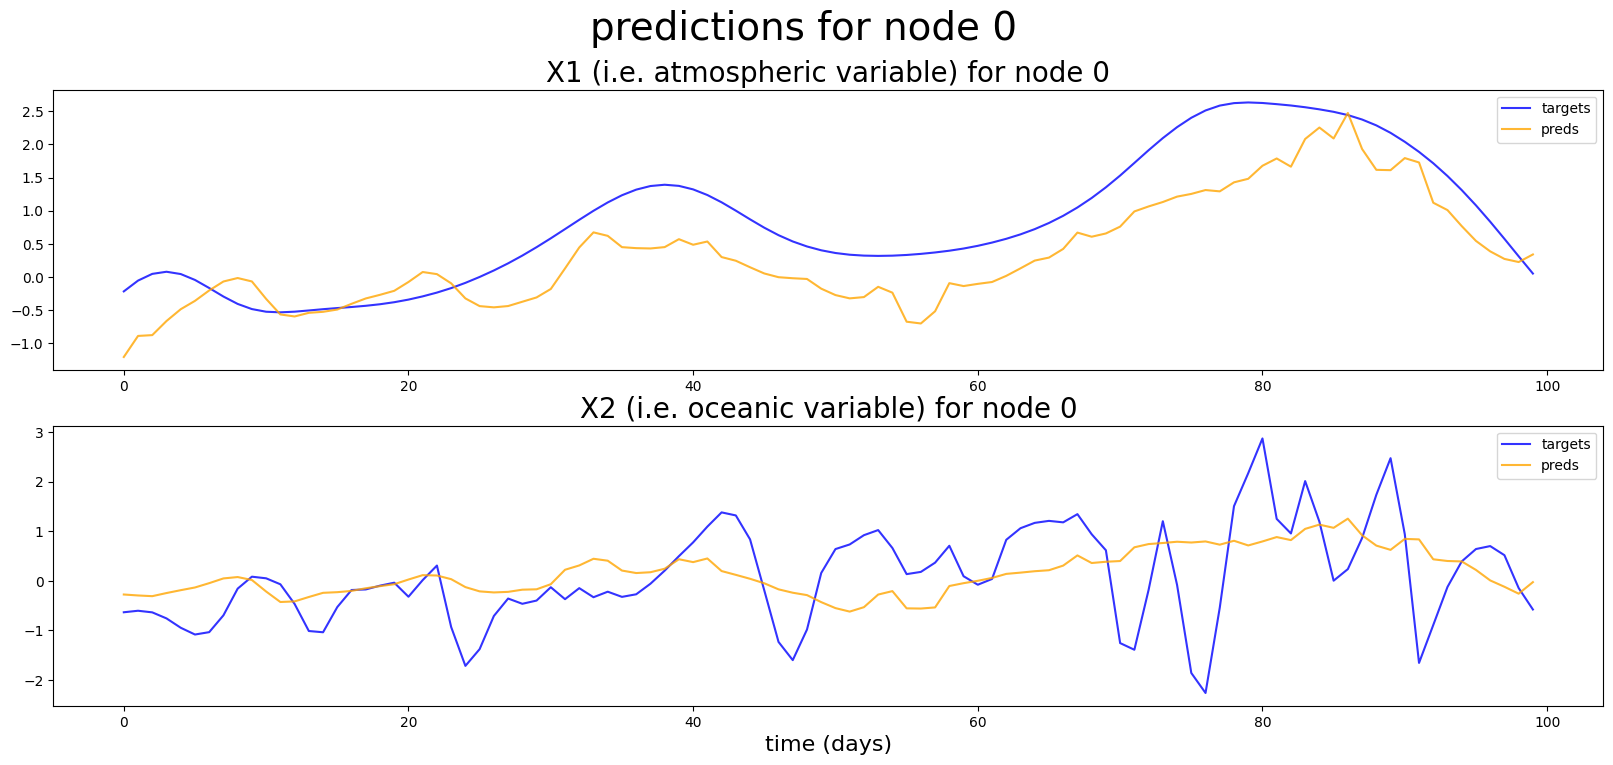

In [26]:
plot_predictions(
    config=get_best_trial_config(study=study10),
    workdir=get_best_trial_workdir(study=study10), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="val", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

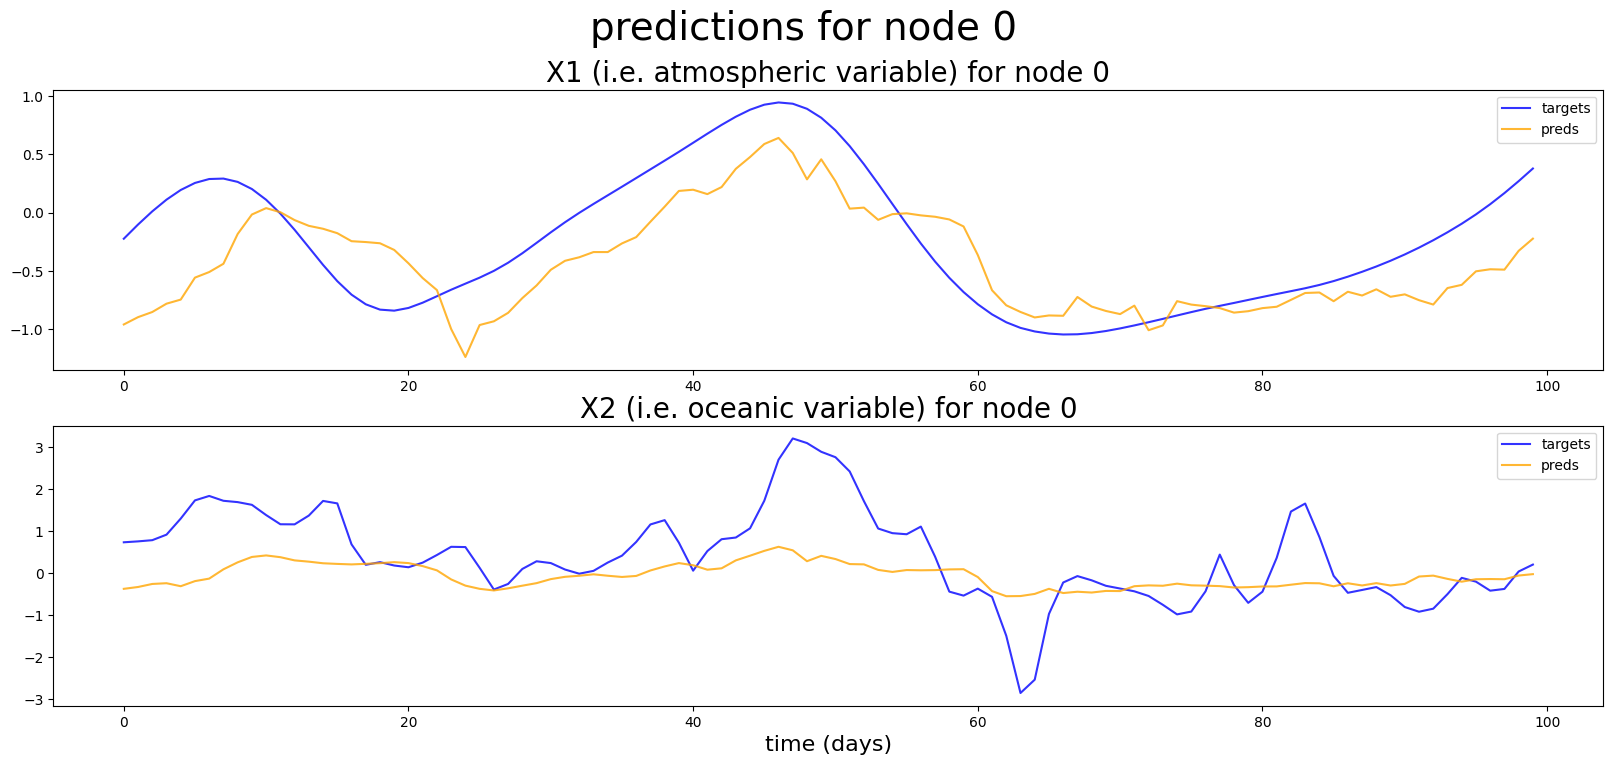

In [27]:
plot_predictions(
    config=get_best_trial_config(study=study10),
    workdir=get_best_trial_workdir(study=study10), # for loading checkpoints 
    plot_ith_rollout_step=0, # 0 indexed # for this study, we have a 4-step rollout 
    # dataset,
    # preds,
    # timestep_duration,
    # n_rollout_steps,
    #  total_steps,
    node=0, # 0-indexed 
    plot_mode="train", # i.e. "train"/"val"/"test"
    datasets=datasets,
    plot_all=False, # if false, only plot the first 100 
)

oh my god its finally working! 

visualize tuning and loss landscape

In [11]:
fig = optuna.visualization.plot_intermediate_values(study10)
fig.show()

In [12]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study10, params=['learning_rate', 'dropout_rate'])
fig.show()

In [13]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study10, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [28]:
study10.optimize(objective_partial, 
                n_trials=50-len(study10.trials), 
                n_jobs=1)

[I 2023-12-01 22:04:54,619] Trial 7 finished with value: 0.6176294684410095 and parameters: {'optimizer': 'adam', 'learning_rate': 0.000196902064282781, 'dropout_rate': 0.10528003316603664, 'activation': 'relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 7, 'node_mlp_2_power': 4}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.61762947



[W 2023-12-01 22:07:17,574] Trial 8 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.006116825049781804, 'momentum': 0.9355485442568404, 'dropout_rate': 0.4031352790649502, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 2, 'node_mlp_2_power': 8} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:07:17,577] Trial 8 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[W 2023-12-01 22:08:40,600] Trial 9 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.0006399335842208817, 'momentum': 0.246328655667184, 'dropout_rate': 0.4802248639792241, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 1, 'node_mlp_2_power': 6} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:08:40,602] Trial 9 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[W 2023-12-01 22:10:02,026] Trial 10 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.012364858693700902, 'momentum': 0.5873514013666936, 'dropout_rate': 0.5016396107538679, 'activation': 'relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 4, 'node_mlp_2_power': 2} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:10:02,027] Trial 10 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[W 2023-12-01 22:12:09,069] Trial 11 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.0394767727148213, 'momentum': 0.11651720607627251, 'dropout_rate': 0.1316904190871749, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 2, 'node_mlp_2_power': 8} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:12:09,070] Trial 11 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[W 2023-12-01 22:13:27,605] Trial 12 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.03453865584179465, 'momentum': 0.25645204644172115, 'dropout_rate': 0.228496996123328, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 3, 'node_mlp_2_power': 4} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:13:27,606] Trial 12 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[I 2023-12-01 22:14:52,045] Trial 13 finished with value: 0.7467036843299866 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0009611672409660332, 'dropout_rate': 0.18966006413496164, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 2, 'node_mlp_2_power': 1}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.7467037



[W 2023-12-01 22:16:14,177] Trial 14 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.0098922159055086, 'momentum': 0.415315952867836, 'dropout_rate': 0.3894486811925652, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 3, 'node_mlp_2_power': 2} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:16:14,178] Trial 14 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[I 2023-12-01 22:17:49,366] Trial 15 finished with value: 0.9293771386146545 and parameters: {'optimizer': 'adam', 'learning_rate': 0.007965970600278448, 'dropout_rate': 0.5213494134503254, 'activation': 'relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 6, 'node_mlp_2_power': 6}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.92937714



[I 2023-12-01 22:20:20,722] Trial 16 finished with value: 0.8405172228813171 and parameters: {'optimizer': 'adam', 'learning_rate': 0.006729424306900271, 'dropout_rate': 0.36260178322829767, 'activation': 'elu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 4, 'node_mlp_2_power': 8}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.8405172



[W 2023-12-01 22:24:41,483] Trial 17 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.00022218319873105658, 'momentum': 0.582165052765875, 'dropout_rate': 0.5428478786041038, 'activation': 'leaky_relu', 'edge_mlp_1_power': 2, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 8, 'node_mlp_2_power': 8} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:24:41,492] Trial 17 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[W 2023-12-01 22:27:12,225] Trial 18 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.022684213159279126, 'momentum': 0.8827190075462217, 'dropout_rate': 0.20566897295849496, 'activation': 'elu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 7, 'node_mlp_2_power': 6} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:27:12,227] Trial 18 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[W 2023-12-01 22:28:55,131] Trial 19 failed with parameters: {'optimizer': 'sgd', 'learning_rate': 0.03686186104920011, 'momentum': 0.5551951966416454, 'dropout_rate': 0.06574371769307034, 'activation': 'relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 1, 'node_mlp_1_power': 7, 'node_mlp_2_power': 4} because of the following error: The value nan is not acceptable.
[W 2023-12-01 22:28:55,133] Trial 19 failed with value Array(nan, dtype=float32).


eval_metrics_dict['val'].compute()['loss'] nan



[I 2023-12-01 22:31:22,670] Trial 20 finished with value: 0.9289597868919373 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0006017965326177576, 'momentum': 0.928634105958094, 'dropout_rate': 0.3345043731125672, 'activation': 'relu', 'edge_mlp_1_power': 1, 'edge_mlp_2_power': 3, 'node_mlp_1_power': 8, 'node_mlp_2_power': 1}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.9289598



[I 2023-12-01 22:33:32,584] Trial 21 finished with value: 0.5119208693504333 and parameters: {'optimizer': 'adam', 'learning_rate': 0.004751180160623132, 'dropout_rate': 0.02791625346808363, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 8, 'node_mlp_2_power': 4}. Best is trial 4 with value: 0.48924770951271057.


eval_metrics_dict['val'].compute()['loss'] 0.51192087



[I 2023-12-01 22:35:40,098] Trial 22 finished with value: 0.48902300000190735 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0035958971638602967, 'dropout_rate': 0.019296333793194245, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 8, 'node_mlp_2_power': 4}. Best is trial 22 with value: 0.48902300000190735.


eval_metrics_dict['val'].compute()['loss'] 0.489023



[I 2023-12-01 22:37:39,055] Trial 23 finished with value: 0.4418514668941498 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0020334879102282613, 'dropout_rate': 0.016209727677836922, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 8, 'node_mlp_2_power': 3}. Best is trial 23 with value: 0.4418514668941498.


eval_metrics_dict['val'].compute()['loss'] 0.44185147



[W 2023-12-01 22:38:45,956] Trial 24 failed with parameters: {'optimizer': 'adam', 'learning_rate': 0.002618814513606767, 'dropout_rate': 0.013096546870264458, 'activation': 'leaky_relu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 4, 'node_mlp_2_power': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/lorenzvenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/py/716jgpq538x2wf_s8t__x9b80000gn/T/ipykernel_48863/973049931.py", line 54, in objective
    state, train_metrics, eval_metrics_dict = train_and_evaluate_with_data(config=config, workdir=workdir, datasets=datasets, trial=trial)
  File "/Users/h.lu/Documents/_code/_research lorenz code/lorenzGNN/utils/jraph_training.py", line 466, in train_and_evaluate_with_data
    state, metrics_update, _ = train_step(
  File "<st

KeyboardInterrupt: 

sgd keeps failing with nans :( I thought about getting rid of it altogether but somehow it was still able to get us one of our lowest trial yet at 0.48 error...... it seems very volatile

it's kind of hard to visualize anything with any meaning with that random 70 trillion error for the first trial.. let's get rid of that for visualization purposes

In [44]:
trials_to_keep = [t for t in study10.get_trials() if (t.state == optuna.trial.TrialState.COMPLETE and t.values[0] < 1)] # TODO PICK UP HERE 
trials_to_keep

[FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.6714913845062256], datetime_start=datetime.datetime(2023, 12, 1, 21, 36, 47, 970663), datetime_complete=datetime.datetime(2023, 12, 1, 21, 38, 49, 435910), params={'optimizer': 'sgd', 'learning_rate': 0.0002483783627777202, 'momentum': 0.7508533198246197, 'dropout_rate': 0.09417768846793652, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 1, 'node_mlp_2_power': 7}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.8941403031349182, 5: 0.6917420625686646, 9: 0.6714913845062256}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd')), 'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'momentum': FloatDistribution(high=0.999, log=False, low=0.0, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'leaky_relu')), 'edge_mlp_1_power': IntD

In [61]:
study10.direction

<StudyDirection.MINIMIZE: 1>

In [45]:
# get study
study_vis, _ = prepare_study(study_name="hparam_study_10_vis")

# add the trials we want to keep to the new study
study_vis.add_trials(trials_to_keep)

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
Global features shape: (1, 1)


[I 2023-12-01 23:17:36,549] A new study created in RDB with name: hparam_study_10_vis


In [46]:
study_vis

In [48]:
study_vis.trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.6714913845062256], datetime_start=datetime.datetime(2023, 12, 1, 21, 36, 47, 970663), datetime_complete=datetime.datetime(2023, 12, 1, 21, 38, 49, 435910), params={'optimizer': 'sgd', 'learning_rate': 0.0002483783627777202, 'momentum': 0.7508533198246197, 'dropout_rate': 0.09417768846793652, 'activation': 'elu', 'edge_mlp_1_power': 3, 'edge_mlp_2_power': 2, 'node_mlp_1_power': 1, 'node_mlp_2_power': 7}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.8941403031349182, 5: 0.6917420625686646, 9: 0.6714913845062256}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd')), 'learning_rate': FloatDistribution(high=0.05, log=True, low=0.0001, step=None), 'momentum': FloatDistribution(high=0.999, log=False, low=0.0, step=None), 'dropout_rate': FloatDistribution(high=0.6, log=False, low=0.0, step=None), 'activation': CategoricalDistribution(choices=('relu', 'elu', 'leaky_relu')), 'edge_mlp_1_power': IntD

In [49]:
fig = optuna.visualization.plot_intermediate_values(study_vis)
fig.show()

In [50]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'dropout_rate'])
fig.show()

In [51]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'edge_mlp_1_power'])
fig.show()

In [52]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'node_mlp_1_power'])
fig.show()

In [53]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['learning_rate', 'optimizer'])
fig.show()

In [55]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['optimizer', 'activation'])
fig.show()

In [57]:
# plot the estimated accuracy surface over hyperparameters:
fig = optuna.visualization.plot_contour(study_vis, params=['activation', 'node_mlp_1_power'])
fig.show()